# Anomaly Detection

Anomaly detection uses different models to detect anomalous data in a stream.  There are many models to chose from and the best choice depends on the characteristics of the data.  Is the data normally distributed?  Is there frequent baseline changes?  Is the data highly seasonal?  Those are some of the questions you need to ask about the data before deciding on a model.

## Normally Distributed Anomalies

If the data is normally distributed, mean and standard deviation can easily be used to detect anomalies.  Nearly impossible values can be thought as anomalous.  

### Detecting Outliers

In normally distributed data, the mean of a series and +/- 3 standard deviations away would cover 99.7% of all values.  Any numbers outside of that threshold, would be considered anomalous.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm                                                                                                                          
import statsmodels.formula.api as smf                                                                                                                 
import statsmodels.tsa.api as smt   

%matplotlib inline

/Users/michaelbeale/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# create a normally distributed array
np.random.seed(42)
mu, sigma = 50, 5
y = np.random.normal(mu, sigma, 1000)
x = [x for x in range(1000)]

#### Histogram

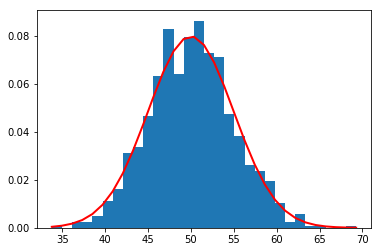

In [3]:
count, bins, ignored = plt.hist(y, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
                linewidth=2, color='r')

#### Plot the Outliers

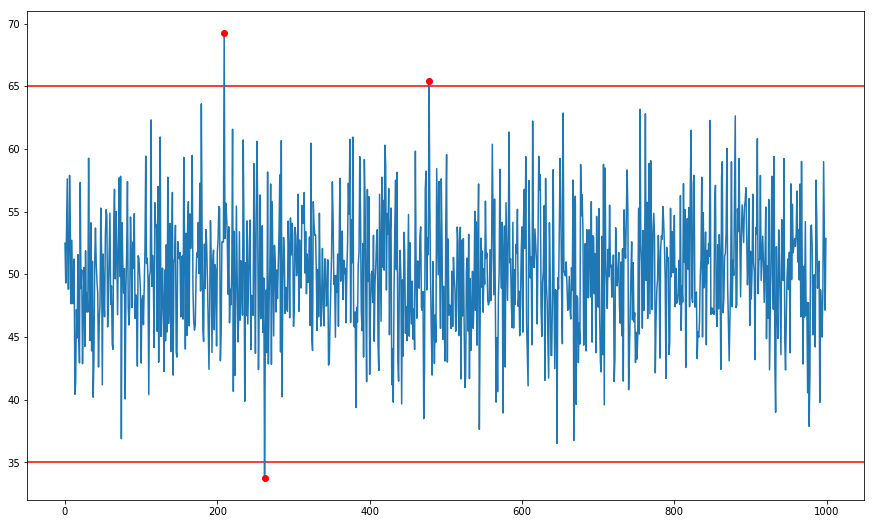

In [4]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)

# plot upper bounds
ax.axhline(mu+(3*sigma), color='r')
# plot lower bounds
ax.axhline(mu-(3*sigma), color='r')

ax.plot(x, y)

# highlight outliers
out_x, out_y = zip(*[[x, y] for x,y in enumerate(y) if y < mu-(3*sigma) or y > mu+(3*sigma)])

ax.plot(out_x, out_y, 'ro')


There are 3 outliers (highlighted by red dots) in this data which is as expected (1000 samples * .03 = 3). This data is anomalous but the threshold could be adjusted depending on what is actually considered anamolous.  For instance you could use +/- 4 times standard deviation (99.994% or 1 in 157887 events).  Below is a table of Table of numerical values from [wikipedia](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

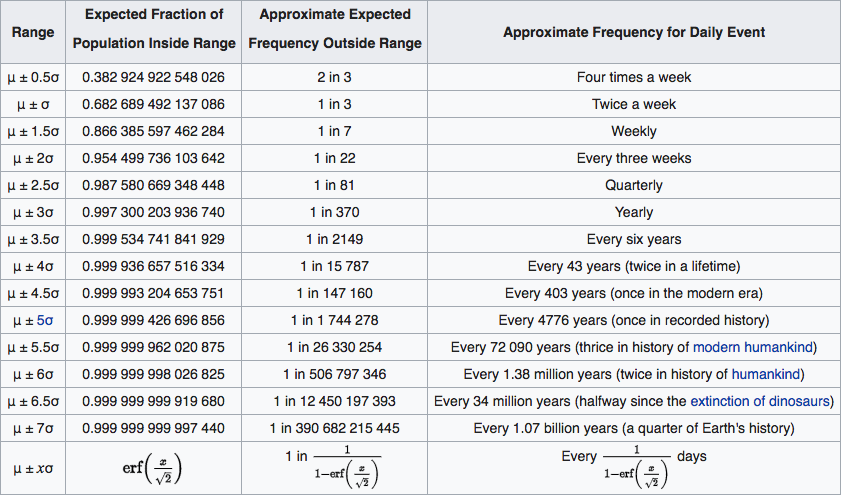

## Detecting Irregular Distributions

Since normally distributed data should follow specific rule so the likelihood that 5 points in a row all fall between the 2 and third deviation is extremely rare (8.1-11%  (0.003^5)).  

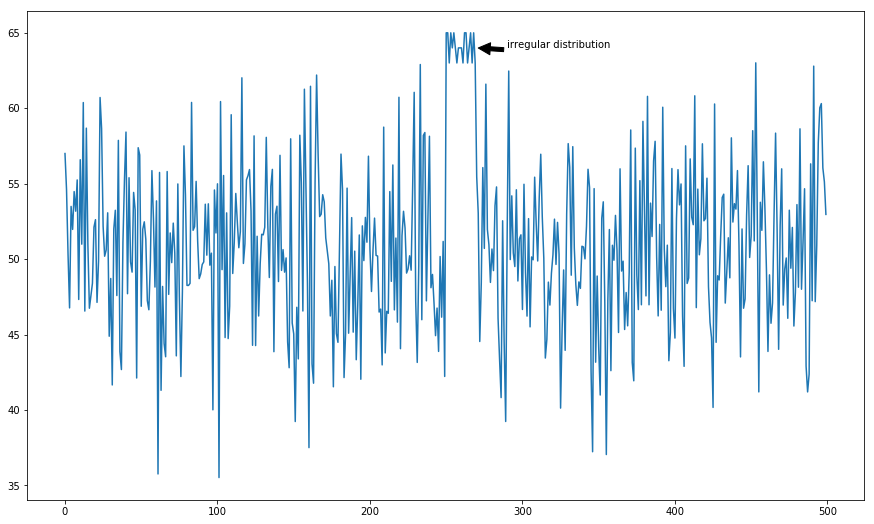

In [5]:
# create normal data with a small window of
mu, sigma = 50, 5

y = np.random.normal(mu, sigma, 500)
for i in range(250, 270,1):
    y[i] = np.random.randint(63, high=66, size=1)
x = [x for x in range(500)]

fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
# plot upper bounds
ax.plot(x, y)

ax.annotate('irregular distribution', xy=(270, 64), xytext=(290, 64),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )



Though none of the points are outliers, the small section of points are all in the same boundary which is causes an anomaly.  We can create function to look for this type of pattern.  For now will just cover the mean + 3 * sigma but it could be consecutive points in any sigma range.

In [6]:
def find_irreg_dist(data, consecutive_points=5):
    """ return an array of x coordinates where the points indidcate a irregular distribution """
    mu = np.mean(data)
    sigma = np.std(data)
    point_counter = 0
    vline = []
    triggering = False
    for i, x in enumerate(data):
        if x > mu+(2 * sigma):
            point_counter += 1
        else:
            if triggering:
                vline.append([i - point_counter, i])
                triggering = False
            point_counter = 0
        if point_counter >= consecutive_points:
            triggering = True
    return vline

Now we plot the chart again with lines indicating the window(s) for the irregular distribution.

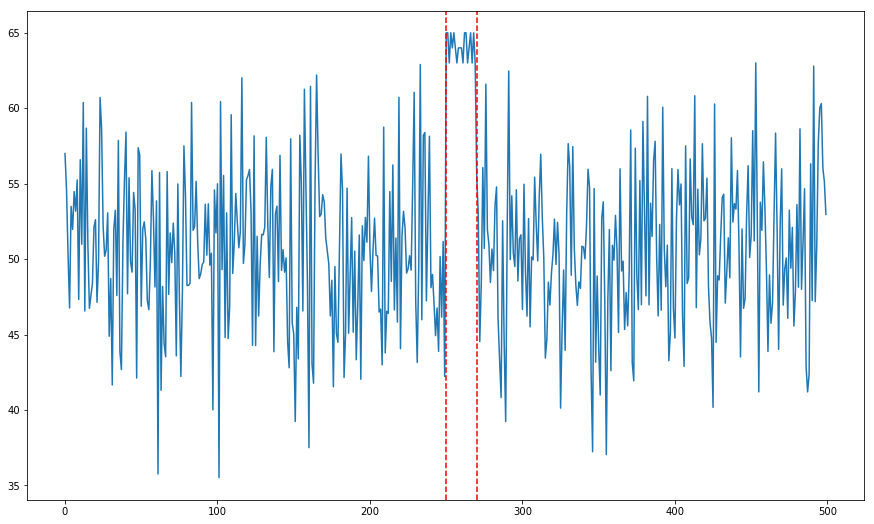

In [7]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
# plot upper bounds
ax.plot(x, y)

for pair in find_irreg_dist(y):
    ax.axvline(x=pair[0], color='r', linestyle='--')
    ax.axvline(x=pair[1], color='r', linestyle='--')


## Detecting Window Irregularites

There can be windows within the series where the mean and deviation differ from the population mean and deviation too much, that can be an anomalous window of data.  This type of detection is more useful with larger amounts of data.

49.4548801214
5.28554138397


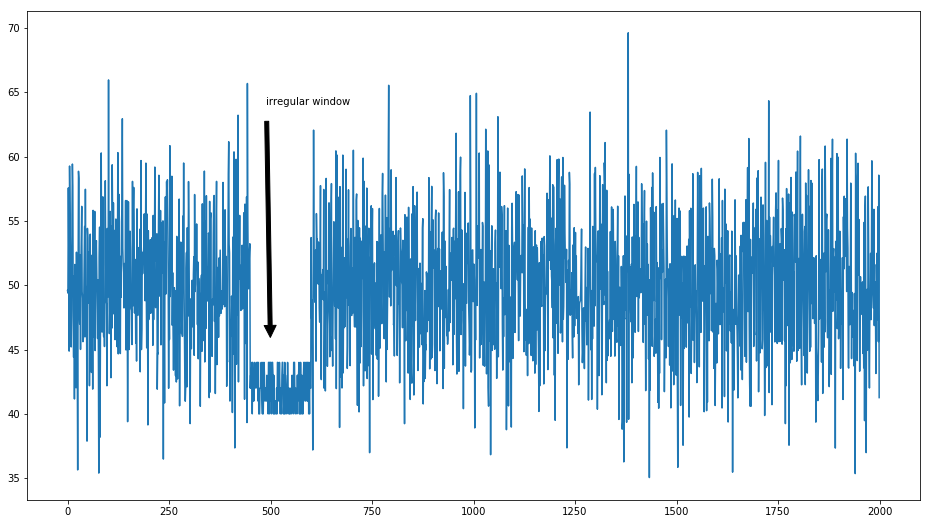

In [8]:
# create normal data with a small window of data with changes to the mean and standard deviation
mu, sigma = 50, 5

y = np.random.normal(mu, sigma, 2000)
for i in range(450, 600,1):
    y[i] = np.random.randint(40, high=45, size=1)
x = [x for x in range(2000)]

fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)
ax.plot(x, y)

ax.annotate('irregular window', xy=(500, 45), xytext=(490, 64),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

print(np.mean(y))
print(np.std(y))

Above we see a window of data where the mean changes for an extended period.  We can test if a window of 100 points or more have a mean which is one sigma below the current mean.  

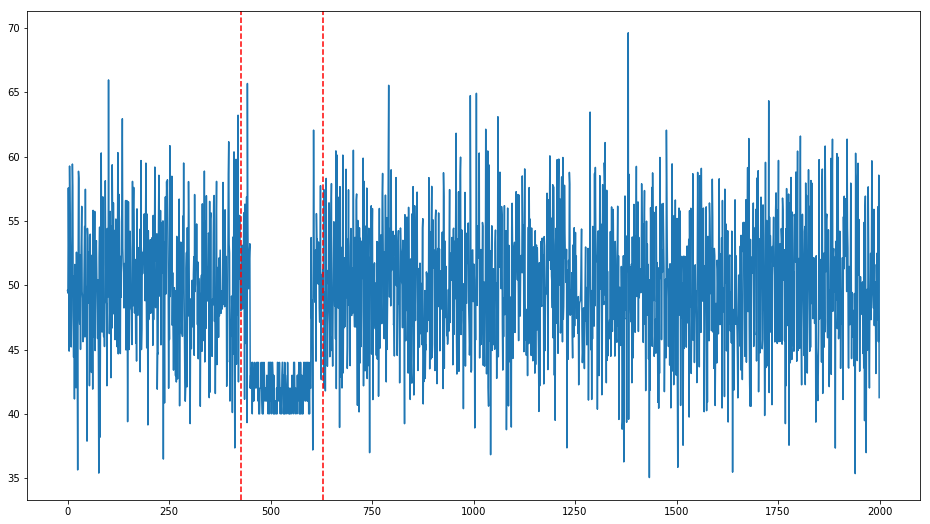

In [9]:
usual_mean = np.mean(y)
usual_std  = np.std(y)

fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)
ax.plot(x, y)


points = 0
active = False
for i in range(100, len(y)):
    window_mean = np.mean(y[i-100:i])
    window_std  = np.std(y[i-100:i])
    if window_mean < usual_mean - usual_std or window_mean > usual_mean + usual_std:
        points += 1
        active = True
    else:
        if active:
            ax.axvline(x=i-(points+100), color='r', linestyle='--')
            ax.axvline(x=i, color='r', linestyle='--')
        points = 0
        active = False

This code just tested for differences in the usual mean, but you could additionally check for changes in the standard deviation as well as change how sensitive the check is to change.

## Anomaly detection in the wild

Most data we get in the real world is not normally distributed and makes alerting based on mean and standard deviation less effective.  Many times models work by removing trend, seasonality, and cycle from a time series to normalize the residuals.

Starting with the simplest model and then changing models if/when the model fails is the best path forward.

### Decomposition

*PROS*: Very Simple.  Robust.  Can handle many different types of data.

*CONS*: Not many options for tuning.

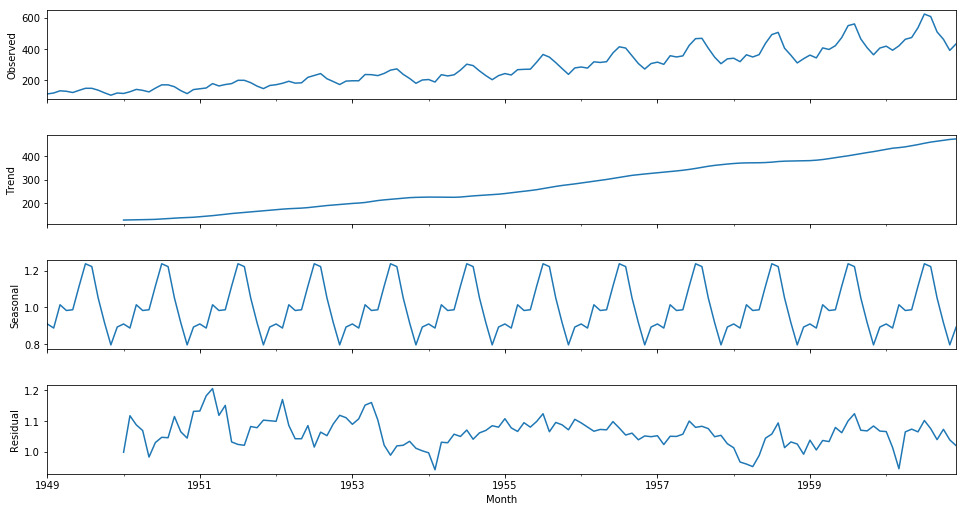

In [10]:
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])
d = smt.seasonal_decompose(air, model='multiplicative', two_sided=False) #use multiplicative because the amplitude is increasing
fig = d.plot()
fig.set_size_inches(15,8)

Here we see trend and seasonality have been removed from the original series and we are left with the residuals.  By first glance the residuals look like they could be normally distributed but we should investigate further to verify.  First plot the historgram.

1.0625204320995818
1.06528696876


/Users/michaelbeale/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/michaelbeale/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


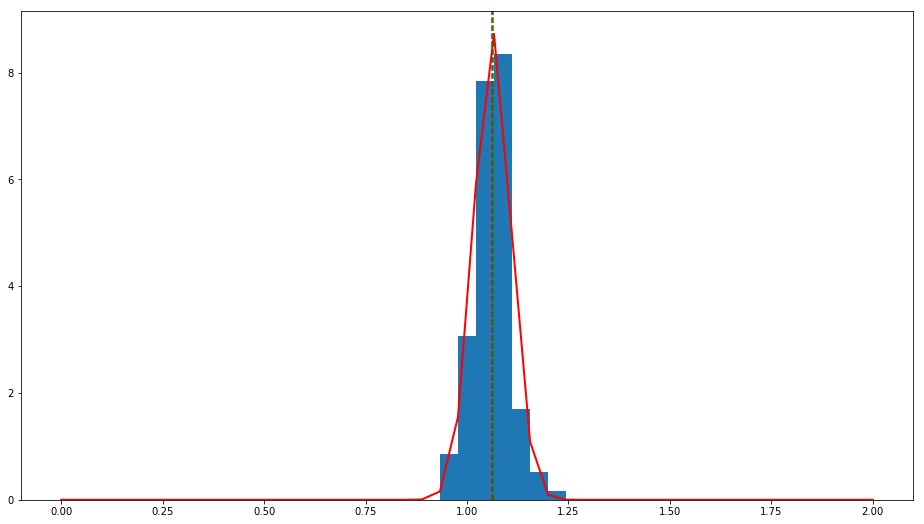

In [11]:
mu     = np.mean(d.resid['n_pass_thousands'])
sigma  = np.std(d.resid['n_pass_thousands'])
median = np.median(d.resid['n_pass_thousands'].dropna())

fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)

count, bins, ignored = plt.hist(d.resid['n_pass_thousands'], 45, range=(0, 2), normed=True)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
                linewidth=2, color='r')

ax.axvline(x=mu, color='r', linestyle='--')
ax.axvline(x=median, color='green', linestyle='--')

That looks normally distributed.  The mean (red dotted line) and the median (green dottted line) are in the middle of the distribution.  We could use the residuals to check for anomalies.


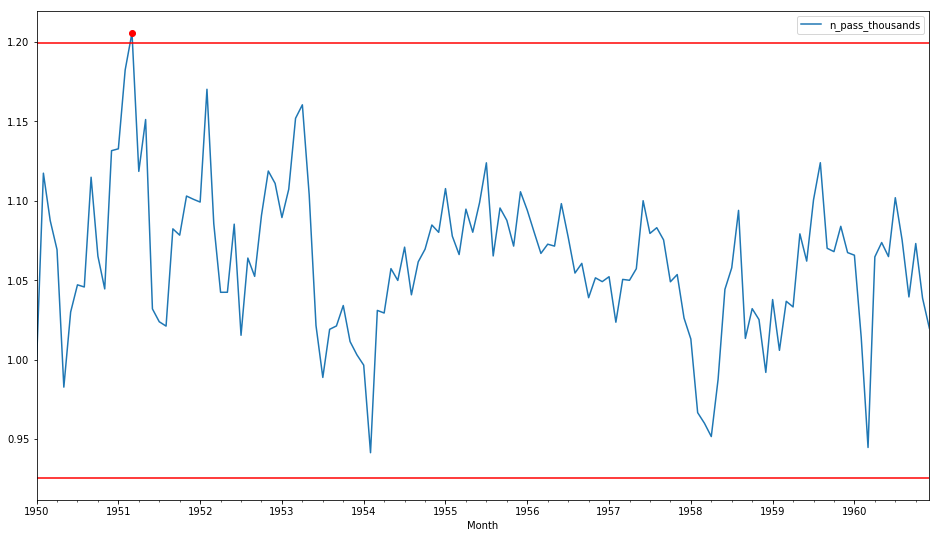

In [120]:
mu    = np.mean(d.resid['n_pass_thousands'])
sigma = np.std(d.resid['n_pass_thousands'])
fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)

d.resid.dropna().plot(ax=ax)

ax.axhline(mu+(3*sigma), 0, 1, color='r')
# plot lower bounds
ax.axhline(mu-(3*sigma), 0, 1, color='r')

#plot the outlier
ax.plot(['1951-03-01 00:00:00'], [1.205775], 'ro')


The previous chart shows one anomalous point using the entire period as a measureing stick.  The min/max values can be influenced by the time period as well.  A point can be anomalous using the last 60 mintues of data but be a good point if using 24 hours of data.  

Adding a low pass filter (moving average) is another approach that can use a moving min/max value.  The seasonal decomposition can be recreated with the addition of an upper and lower bounds to specify the accepted range.

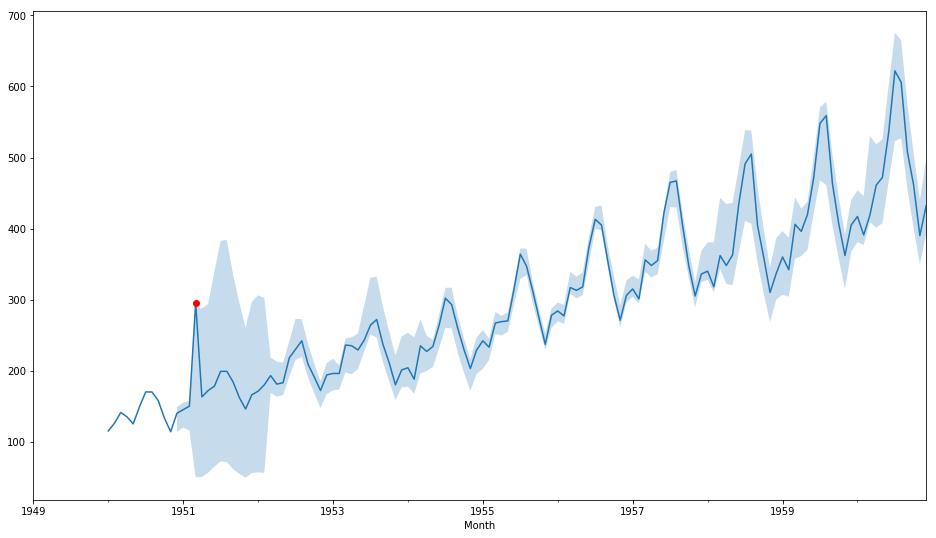

In [137]:
fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)

# added an outlier
d.resid.loc['1951-03-01 00:00:00', 'n_pass_thousands'] = 2
# calc rolling mean and std
r_mean = d.resid.rolling(12).mean() # optionally using a centered mean/std could be experimented with
r_std = d.resid.rolling(12).std()

# multiply the standard deviation by 3 to set the bounds
r_std *= 3

# create a dataframe for mean and std
m = pd.DataFrame({"mean": r_mean['n_pass_thousands'], "std": r_std['n_pass_thousands']}, index=r_mean.index)

# create upper and lower bounds
m['lower'] = m['mean'] - m['std']
m['upper'] = m['mean'] + m['std']

# recompose the original series
recompose = d.trend * d.seasonal * d.resid

# create the bounds through recomposition
recompose['lower_bounds'] = d.trend['n_pass_thousands'] * d.seasonal['n_pass_thousands'] * m['lower']
recompose['upper_bounds'] = d.trend['n_pass_thousands'] * d.seasonal['n_pass_thousands'] * m['upper']

# plot the series
recompose['n_pass_thousands'].plot(ax=ax)
# fill the boundaries
ax.fill_between(recompose.index, recompose['lower_bounds'], recompose['upper_bounds'], alpha=.25)
outliers = recompose[(recompose['n_pass_thousands'] > recompose['upper_bounds']) | (recompose['n_pass_thousands'] < recompose['lower_bounds'])]['n_pass_thousands'].dropna()
if len(outliers > 0):
    outliers.plot(color='red',linestyle='none', marker='o', ax=ax)



Above is the light blue band shows the boundaries where the solid blue line is the actual series.  Any points that fall outside the boundaries would be considered anomalous.

### Decomposition with moving median

Decomposition with a moving average can be heavily effected by anomalies.  If there is a large volume of data or the data contains a large amount of outliers, using median for trend removal is a better option. 

### Low Pass Filter

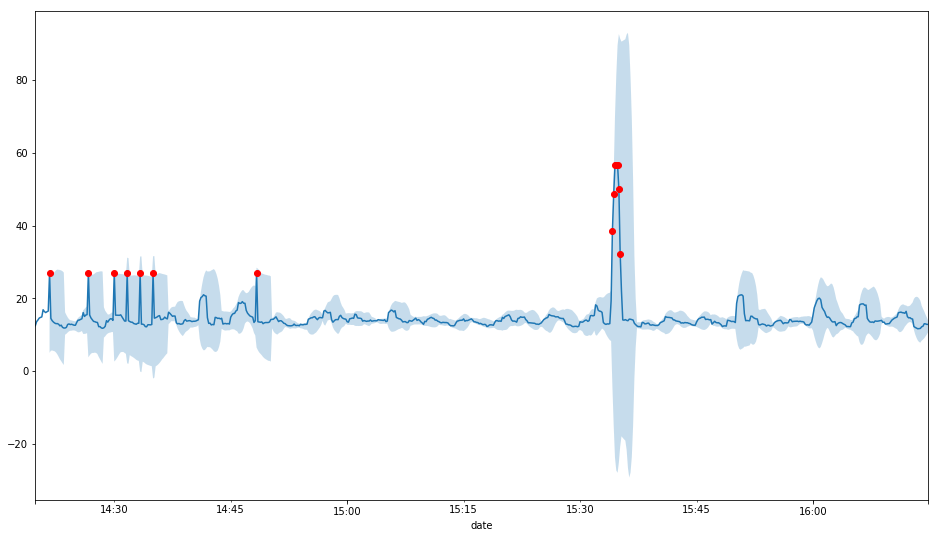

In [162]:
from pandas.core.nanops import nanmean as pd_nanmean
#air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])
df = pd.read_csv('data/response_times.csv', index_col=0, parse_dates=True).iloc[:6*60*2]
fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)

#add some outliers
df['value'].iloc[[200,90, 120, 40, 70, 100, 110, 120]] = 27

freq = 6*5
trend = df.rolling(freq).median()
period_averages = np.array([pd_nanmean(trend[i::freq]) for i in range(freq)])
period_averages -= np.mean(period_averages)
nobs = len(df)
seasonal = np.tile(period_averages, nobs // freq + 1)[:nobs]
resids = df['value'] - trend['value'] - seasonal

r_std = resids.rolling(12).std() * 3
r_mean = resids.rolling(12).mean()

m = pd.DataFrame({"mean": r_mean, "std": r_std}, index=r_mean.index)

mu = np.mean(df['value'])
sigma = np.std(df['value'])
lower = mu - (3*sigma)
upper = mu + (3*sigma)

# create upper and lower bounds
m['lower'] = m['mean'] - m['std']
m['upper'] = m['mean'] + m['std']
# print(m.columns)
# recompose the original series
#recompose = trend['value'] * seasonal * resids
recompose = pd.DataFrame({'value': trend['value'] + seasonal + resids}, index=trend.index)

# create the bounds through recomposition
recompose['lower_bounds'] = trend['value'] + seasonal + m['lower']
recompose['upper_bounds'] = trend['value'] + seasonal + m['upper']


# plot the series
recompose['value'].dropna().plot(ax=ax)
# fill the boundaries
ax.fill_between(recompose.index, recompose['lower_bounds'], recompose['upper_bounds'], alpha=.25)
#outliers = recompose[(recompose['value'] > recompose['upper_bounds']) | (recompose['value'] < recompose['lower_bounds'])]['value'].dropna()
outliers = recompose[(recompose['value'] > upper) | (recompose['value'] < lower)]['value'].dropna()

if len(outliers > 0):
    outliers.plot(color='red',linestyle='none', marker='o', ax=ax)


### Population level min/max

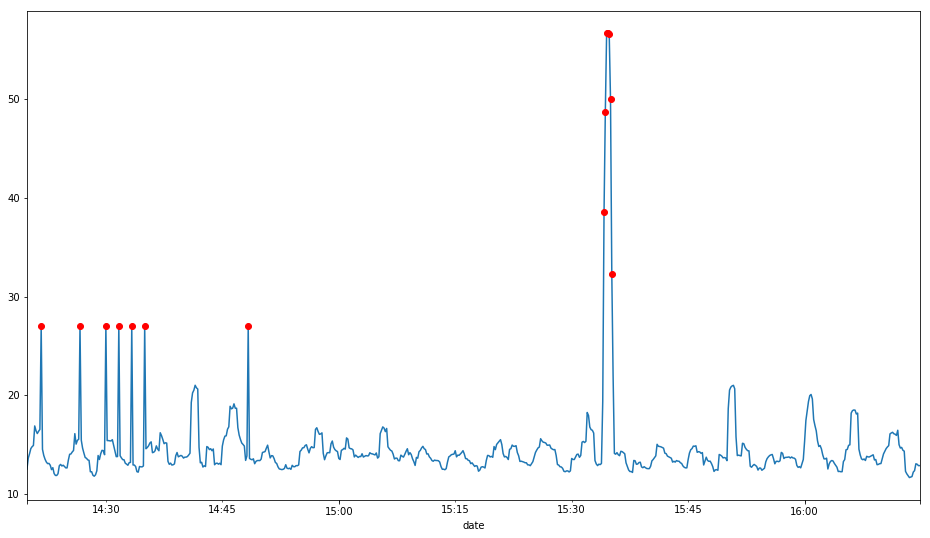

In [163]:
mu = np.mean(recompose['value'])
sigma = np.std(recompose['value'])

lower = mu - (3*sigma)
upper = mu + (3*sigma)

fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)


recompose['value'].dropna().plot(ax=ax)
outliers = recompose[(recompose['value'] > upper) | (recompose['value'] < lower)]['value'].dropna()

if len(outliers > 0):
    outliers.plot(color='red',linestyle='none', marker='o', ax=ax)



### Distribution of residuals

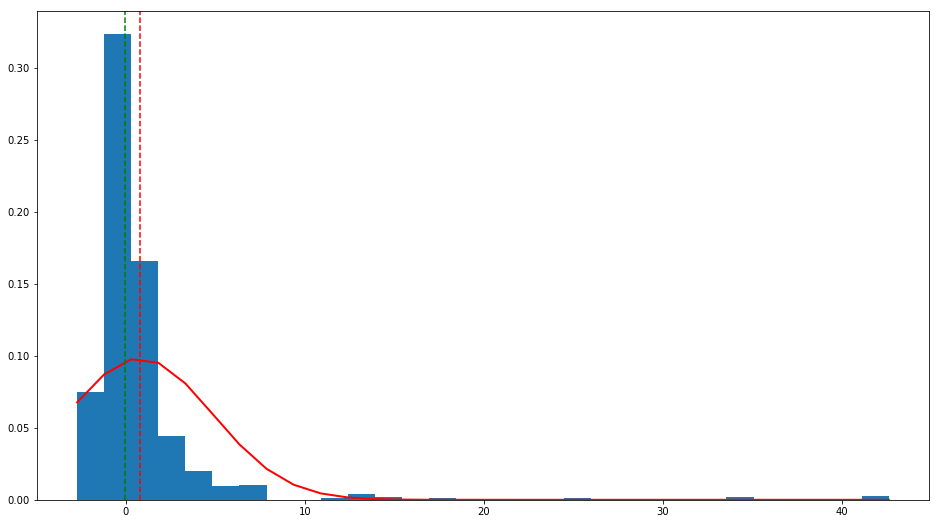

In [165]:
mu     = np.mean(resids.dropna())
sigma  = np.std(resids.dropna())
median = np.median(resids.dropna())

fig = plt.figure(1, figsize=(16, 9))
ax = fig.add_subplot(111)

count, bins, ignored = plt.hist(resids.dropna(), 30, normed=True)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
                linewidth=2, color='r')

ax.axvline(x=mu, color='r', linestyle='--')
ax.axvline(x=median, color='green', linestyle='--')

### Density-Based

In [166]:
# KNN and local outlier factor(LOF)

### Clustering-Based

In [167]:
# kmeans


### Kalman Filtering

### Hidden Markov Models

### Nueral Networks

### SARIMA(X)

### Exponential Smoothing

### Change Point Detection

## Typical time series patterns

There are many models and filters to chose from.  Some require historical data while others do not.  Some handle seasonal data well, other do not.  Identifying the correct model for the type of data is an important first step.

In [ ]:
### 